### To Read the data

In [1]:
import pandas as pd

In [2]:

# Load the CSV file into a DataFrame
df = pd.read_csv('data.csv')

In [3]:
df.head()

,Date,Closing
0,04-12-2020,1411.60
1,07-12-2020,1414.30
2,08-12-2020,1441.70
3,09-12-2020,1437.95
4,10-12-2020,1442.70


In [4]:
df.shape

(259, 2)

### Convert the data into time series

In [5]:
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')

# Set 'Date' as index to create a time series
df.set_index('Date', inplace=True)

# (Optional) Sort by date just in case
df.sort_index(inplace=True)

# Final time series DataFrame
print(df.head())

            Closing
Date               
2020-12-04  1411.60
2020-12-07  1414.30
2020-12-08  1441.70
2020-12-09  1437.95
2020-12-10  1442.70


### Missing and Null Values

In [6]:
# Generate a date range between min and max dates
full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='B')  # 'B' = business days

# Find missing dates
missing_dates = full_range.difference(df.index)
print("Missing Dates:\n", missing_dates)

Missing Dates:
 DatetimeIndex([], dtype='datetime64[ns]', freq='B')


In [7]:
print(df.isnull().sum())

Closing    0
dtype: int64


In [8]:
print("Duplicate Dates:", df.index.duplicated().sum())

Duplicate Dates: 0


In [9]:
print(df.index.dtype)     # Should be datetime64[ns]
print(df.dtypes)          # 'Closing' should be float or numeric

datetime64[ns]
Closing    float64
dtype: object


### Visualization of data

           Closing
count   259.000000
mean   2796.839768
std    1135.521589
min    1411.600000
25%    1760.700000
50%    2441.150000
75%    3935.525000
max    4988.950000


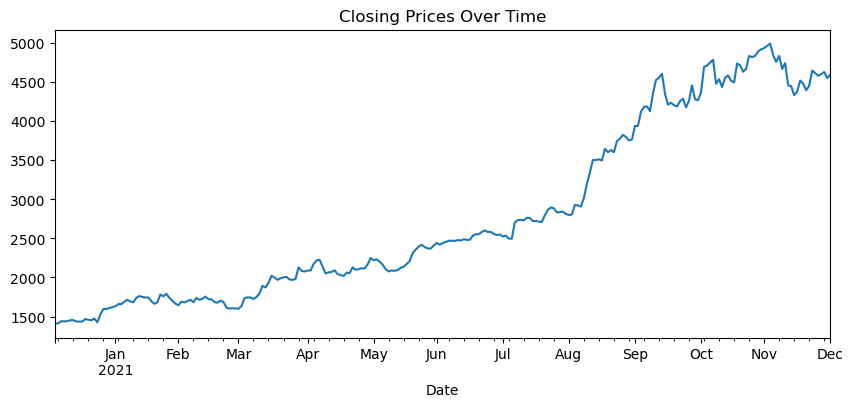

In [10]:
# Simple statistical summary
print(df.describe())

# Optional: Visual method
import matplotlib.pyplot as plt
df['Closing'].plot(title='Closing Prices Over Time', figsize=(10,4))
plt.show()


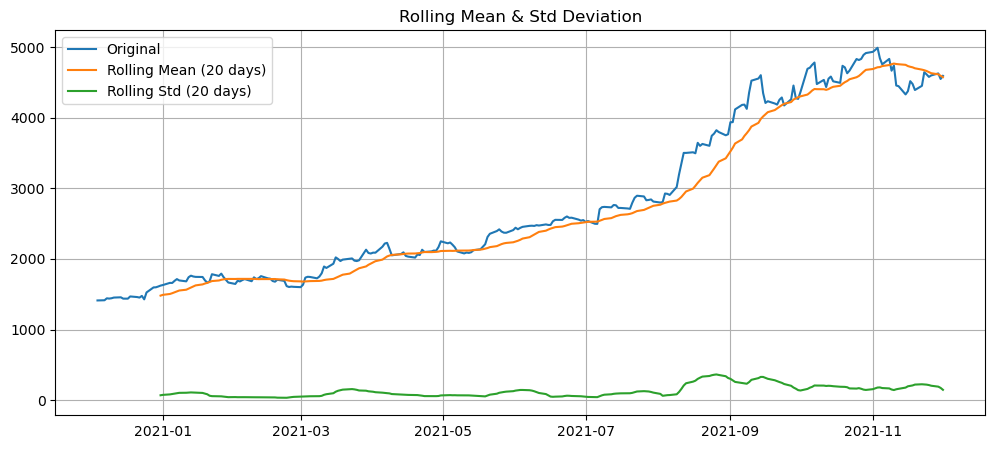

In [11]:
rolling_mean = df['Closing'].rolling(window=20).mean()
rolling_std = df['Closing'].rolling(window=20).std()

plt.figure(figsize=(12, 5))
plt.plot(df['Closing'], label='Original')
plt.plot(rolling_mean, label='Rolling Mean (20 days)')
plt.plot(rolling_std, label='Rolling Std (20 days)')
plt.title('Rolling Mean & Std Deviation')
plt.legend()
plt.grid(True)
plt.show()


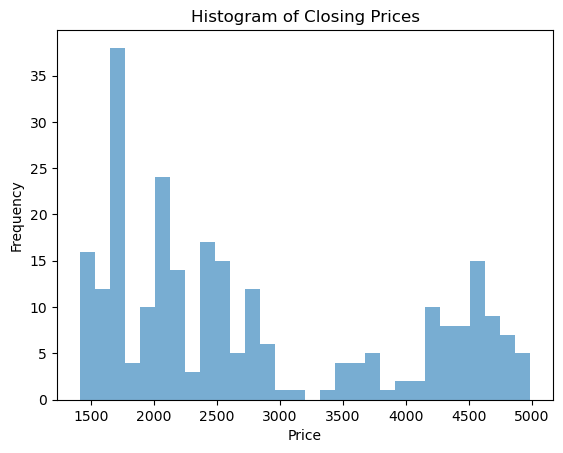

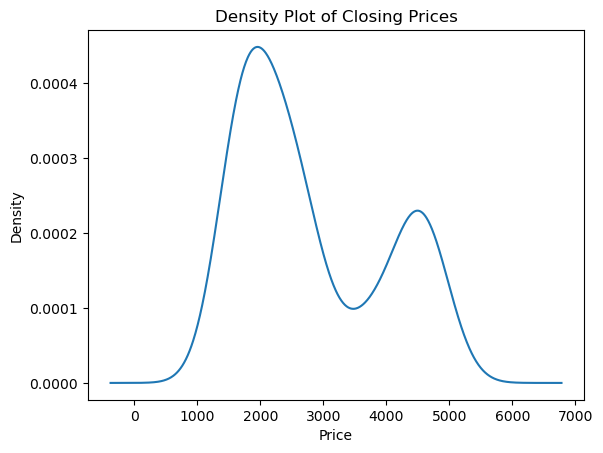

In [12]:
df['Closing'].plot(kind='hist', bins=30, alpha=0.6, title='Histogram of Closing Prices')
plt.xlabel('Price')
plt.show()

# KDE
df['Closing'].plot(kind='kde', title='Density Plot of Closing Prices')
plt.xlabel('Price')
plt.show()


### Outliers identification and treatement

In [13]:
Q1 = df['Closing'].quantile(0.25)
Q3 = df['Closing'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Find outliers
outliers = df[(df['Closing'] < lower_bound) | (df['Closing'] > upper_bound)]
print(outliers)


Empty DataFrame
Columns: [Closing]
Index: []


In [14]:
from scipy.stats import zscore

# Calculate z-scores
df['z_score'] = zscore(df['Closing'])

# Define threshold (usually 3 or -3)
outliers = df[(df['z_score'] > 3) | (df['z_score'] < -3)]
print(outliers)

# Drop the extra column if no longer needed
#df.drop(columns='z_score', inplace=True)


Empty DataFrame
Columns: [Closing, z_score]
Index: []


### Timeseries Decomposition

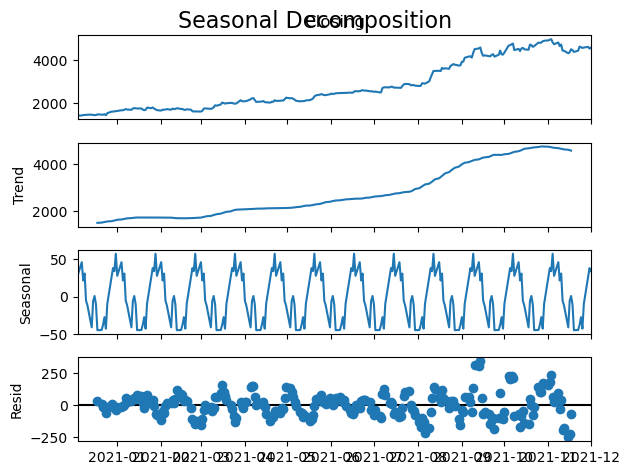

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose

# If daily data, choose model and period (e.g., 20 days for monthly)
decomposition = seasonal_decompose(df['Closing'], model='additive', period=20)

decomposition.plot()
plt.suptitle('Seasonal Decomposition', fontsize=16)
plt.show()


### Dicky fuller test to check stationery

In [16]:
from statsmodels.tsa.stattools import adfuller

# Run ADF test on the 'Closing' column
result = adfuller(df['Closing'])

# Display results
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value}')


ADF Statistic: -0.007529
p-value: 0.957905
Critical Values:
   1%: -3.455952927706342
   5%: -2.8728086526320302
   10%: -2.572774990685656


In [17]:
df['Closing_diff'] = df['Closing'].diff()
df.dropna(inplace=True)  # Remove the first NaN


In [18]:
df.head(2)

,Closing,z_score,Closing_diff
Date,,,
2020-12-07,1414.3,-1.219894,2.7
2020-12-08,1441.7,-1.195718,27.4


In [19]:

# Run ADF test on the 'Closing' column
result = adfuller(df['Closing_diff'])

# Display results
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value}')


ADF Statistic: -15.394909
p-value: 0.000000
Critical Values:
   1%: -3.4560535712549925
   5%: -2.8728527662442334
   10%: -2.5727985212493754


### Plot auto correlation and partial auto correlation

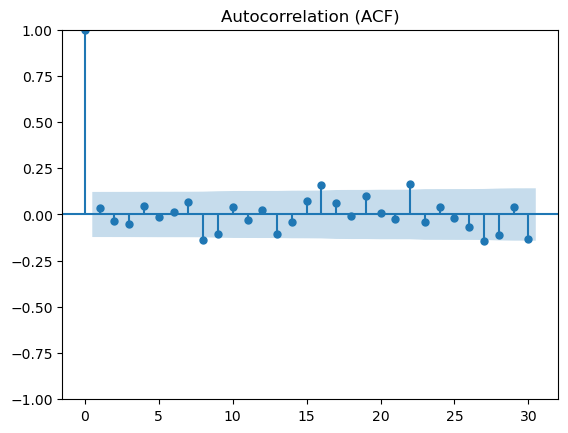

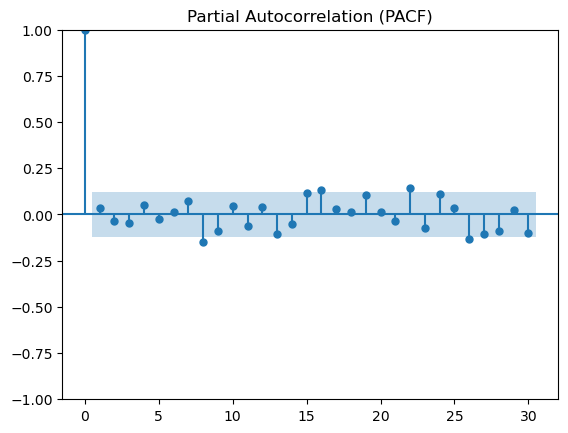

In [20]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df['Closing_diff'].dropna(), lags=30)
plt.title('Autocorrelation (ACF)')
plt.show()

plot_pacf(df['Closing_diff'].dropna(), lags=30)
plt.title('Partial Autocorrelation (PACF)')
plt.show()


### Split the data into train and test

In [21]:
import pandas as pd

# Ensure 'Date' is datetime and set as index
df.index = pd.to_datetime(df.index)

# Sort by date if not already sorted
df = df.sort_index()

# Get the max date and subtract 2 months for splitting
last_date = df.index.max()
two_months_ago = last_date - pd.DateOffset(months=2)

# Split the data
train = df[df.index < two_months_ago]
test = df[df.index >= two_months_ago]

print("Train Set Range:", train.index.min(), "to", train.index.max())
print("Test Set Range:", test.index.min(), "to", test.index.max())


Train Set Range: 2020-12-07 00:00:00 to 2021-09-30 00:00:00
Test Set Range: 2021-10-01 00:00:00 to 2021-12-01 00:00:00


### Build Arima model

In [22]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

C:\Users\manju\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
C:\Users\manju\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
C:\Users\manju\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


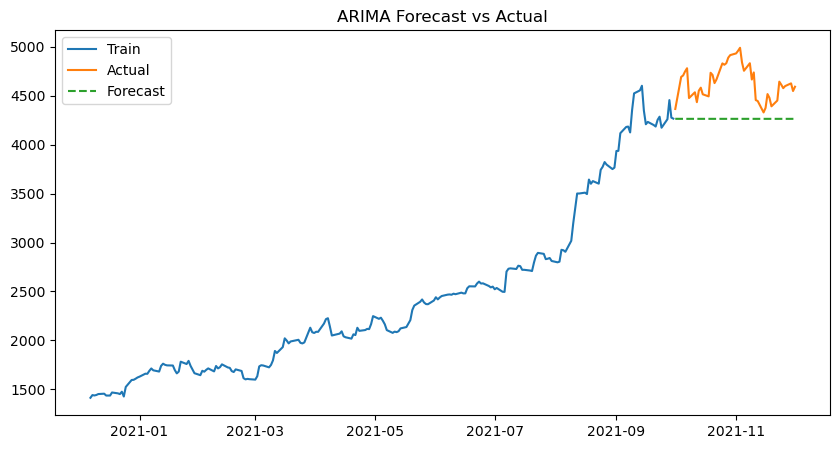

RMSE: 415.64
MAPE: 8.02%


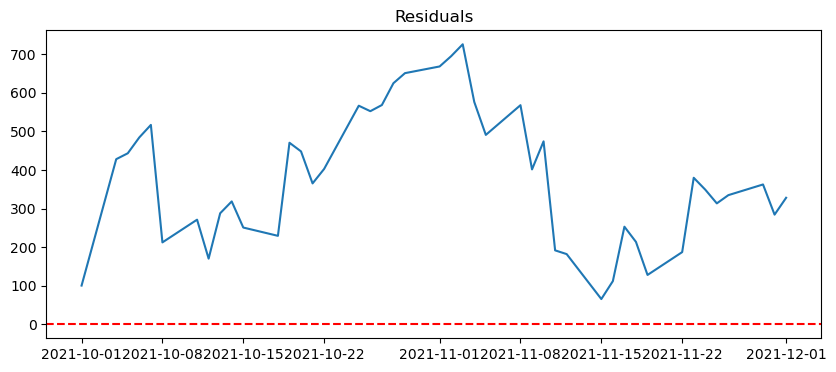

In [23]:

# Fit ARIMA model (basic order for differenced stationary data)
model = ARIMA(train['Closing'], order=(1,1,0))  # (p,d,q) = (1,1,0)
fitted_model = model.fit()

# Forecast on test data
forecast = fitted_model.forecast(steps=len(test))
forecast.index = test.index  # Align forecast index with test

# Plot actual vs forecast
plt.figure(figsize=(10,5))
plt.plot(train.index, train['Closing'], label='Train')
plt.plot(test.index, test['Closing'], label='Actual')
plt.plot(forecast.index, forecast, label='Forecast', linestyle='--')
plt.legend()
plt.title("ARIMA Forecast vs Actual")
plt.show()

# Evaluate
rmse = np.sqrt(mean_squared_error(test['Closing'], forecast))
mape = mean_absolute_percentage_error(test['Closing'], forecast) * 100

print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

# Plot residuals
residuals = test['Closing'] - forecast
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()


### Build sarimax model

In [29]:
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import statsmodels.api as sm

SARIMA RMSE: 268.05
SARIMA MAPE: 5.23 %


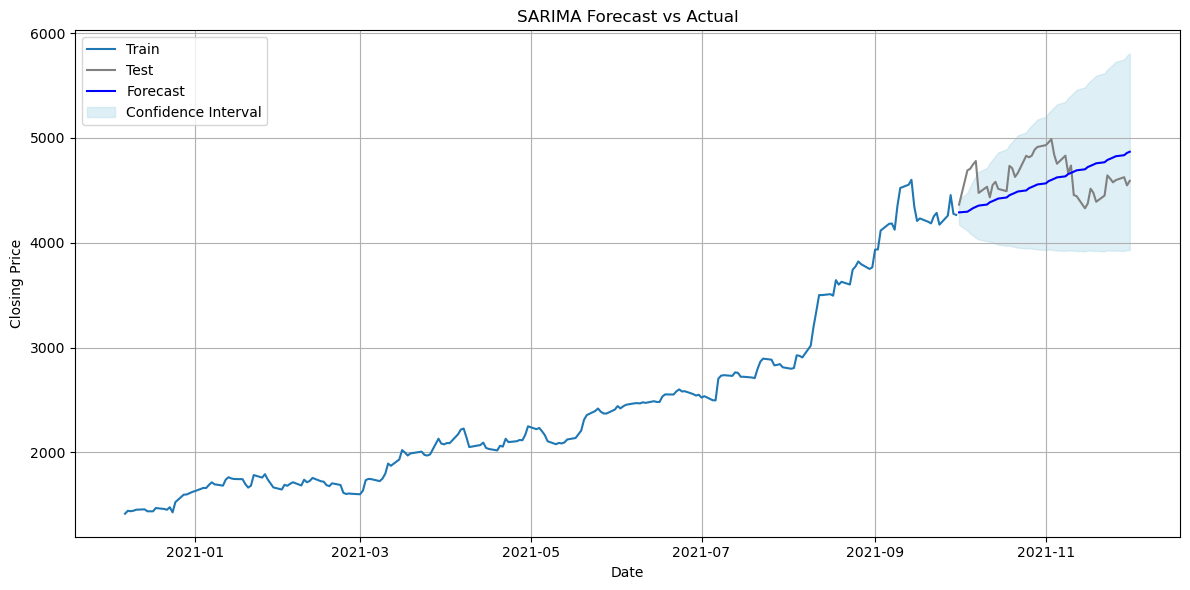

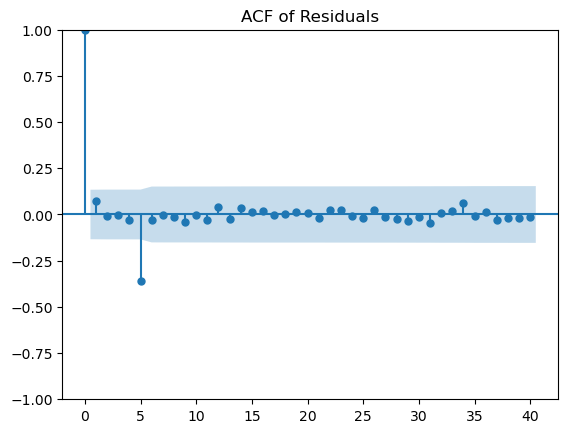

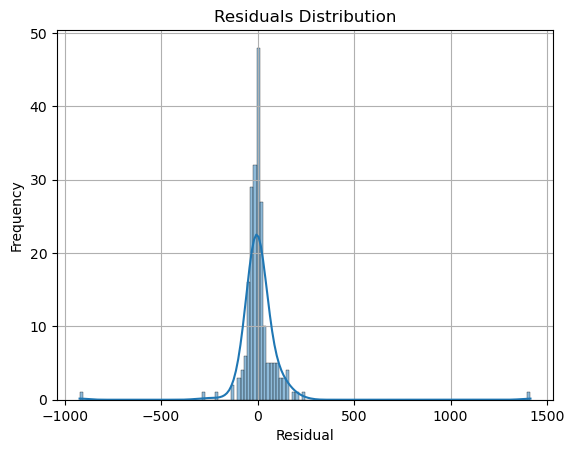

In [30]:
train = train.asfreq('B')
test = test.asfreq('B')

# Fit SARIMA model: (1,1,1)(1,1,1,5) → Weekly seasonality for business days
model = SARIMAX(train['Closing'],
                order=(1,1,1),
                seasonal_order=(1,1,1,5),
                enforce_stationarity=False,
                enforce_invertibility=False)

result = model.fit(disp=False)

# Forecast with confidence interval
forecast_result = result.get_forecast(steps=len(test))
forecast_mean = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

# Evaluation
rmse = np.sqrt(mean_squared_error(test['Closing'], forecast_mean))
mape = mean_absolute_percentage_error(test['Closing'], forecast_mean) * 100

print("SARIMA RMSE:", round(rmse, 2))
print("SARIMA MAPE:", round(mape, 2), "%")

# Plot forecast vs actual + confidence intervals
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Closing'], label='Train')
plt.plot(test.index, test['Closing'], label='Test', color='gray')
plt.plot(test.index, forecast_mean, label='Forecast', color='blue')
plt.fill_between(test.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1],
                 color='lightblue', alpha=0.4, label='Confidence Interval')
plt.title("SARIMA Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Residual diagnostics
residuals = result.resid.dropna()

# ACF plot of residuals
sm.graphics.tsa.plot_acf(residuals, lags=40)
plt.title("ACF of Residuals")
plt.show()

# Histogram of residuals
sns.histplot(residuals, kde=True)
plt.title("Residuals Distribution")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

### additional exploration

In [25]:
train_series = train['Closing']
test_series = test['Closing']

In [26]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np

# Fit Holt-Winters
model = ExponentialSmoothing(train_series, trend='add', seasonal='add', seasonal_periods=12)
fit = model.fit()

# Forecast
forecast = fit.forecast(len(test_series))

# Evaluate
rmse = np.sqrt(mean_squared_error(test_series, forecast))
mape = mean_absolute_percentage_error(test_series, forecast) * 100

print(f"Holt-Winters RMSE: {rmse:.2f}")
print(f"Holt-Winters MAPE: {mape:.2f} %")


Holt-Winters RMSE: 321.47
Holt-Winters MAPE: 6.03 %


C:\Users\manju\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


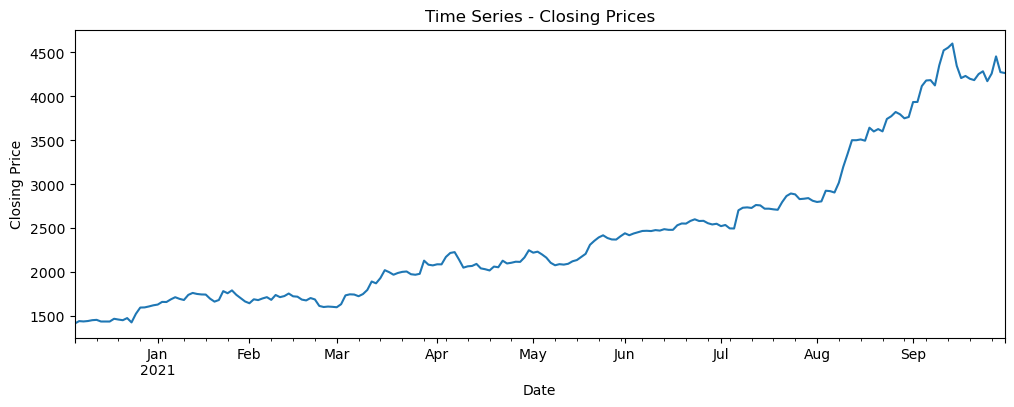

In [31]:
train['Closing'].plot(figsize=(12, 4), title='Time Series - Closing Prices')
plt.ylabel('Closing Price')
plt.show()


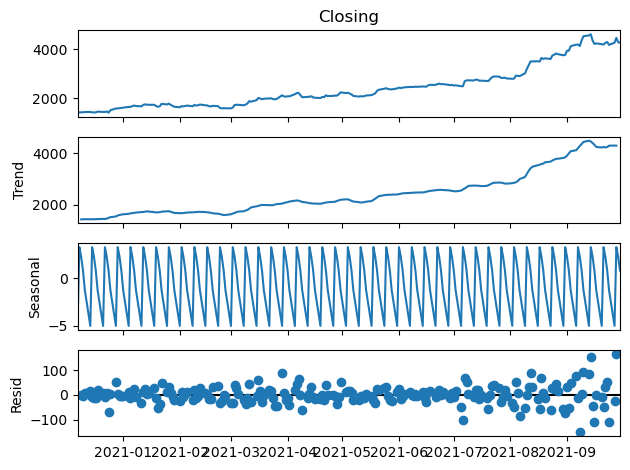

In [32]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose using multiplicative or additive model
decomposition = seasonal_decompose(train['Closing'], model='additive', period=5)  # try 5, 7, or 30 depending on data

decomposition.plot()
plt.show()


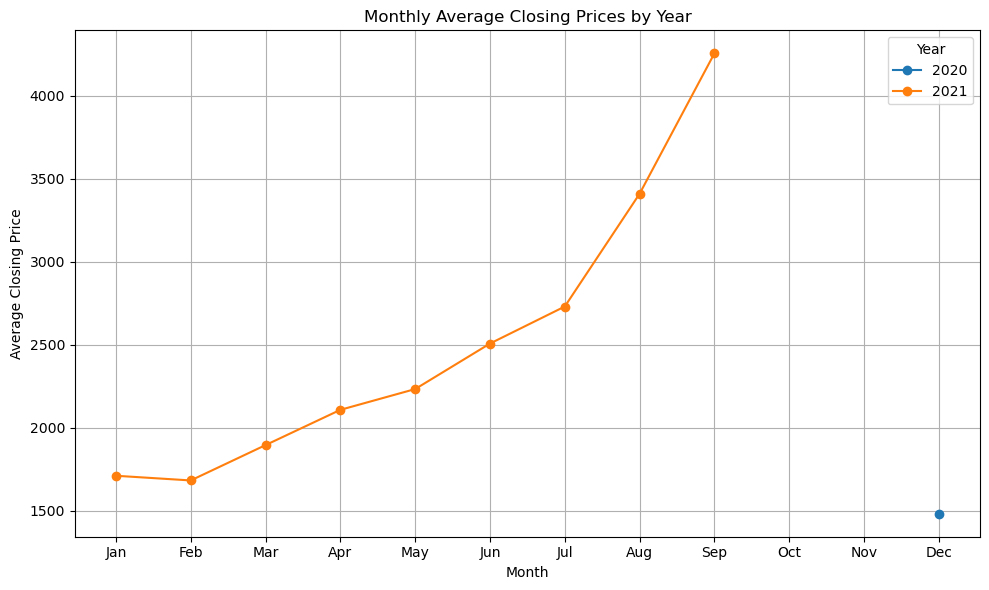

In [35]:
import pandas as pd
import matplotlib.pyplot as plt

# Create copy and extract Month & Year
df = train.copy()
df['Year'] = df.index.year
df['Month'] = df.index.month

# Group by Year and Month, then take mean
monthly_avg = df.groupby(['Year', 'Month'])['Closing'].mean().unstack(0)

# Plot
monthly_avg.plot(kind='line', figsize=(10,6), marker='o')
plt.title("Monthly Average Closing Prices by Year")
plt.xlabel("Month")
plt.ylabel("Average Closing Price")
plt.xticks(ticks=range(1,13), labels=[
    'Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'
])
plt.legend(title="Year")
plt.grid(True)
plt.tight_layout()
plt.show()
